<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

# DataDreamer Tutorial: Generating a dataset for instance segmentation, training a model, and deploying it to the OAK (optional)

In [1]:
!pip install -q datadreamer@git+https://github.com/luxonis/datadreamer@feat/add-instance-segmentation

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Generate a dataset with your own classes (might take some time to download all models)

Make sure you are using the GPU runtime type (in Google Colab).

~4 min to generate 28 images

~43 secs to annotate them

In [2]:
!datadreamer --save_dir generated_dataset \
             --class_names tractor horse bear \
             --prompts_number 28 \
             --prompt_generator simple \
             --num_objects_range 1 1 \
             --image_generator sdxl-turbo \
             --task instance-segmentation \
             --disable_lm_filter \
             --annotator_size base \
             --use_tta \
             --image_annotator owlv2-fastsam \
             --conf_threshold 0.2 \
             --seed 42

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
INFO     Profanity filter is checking classes: ['tractor', 'horse', 'bear']  ]8;id=234053;file:///usr/local/lib/python3.10/dist-packages/datadreamer/prompt_generation/profanity_filter.py\profanity_filter.py]8;;\:]8;id=146316;file:///usr/local/lib/python3.10/dist-packages/datadreamer/prompt_generation/profanity_filter.py#170\170]8;;\
INFO     Initializing SDXL Turbo on cuda...                         ]8;id=234053;file:///usr/local/lib/python3.10/dist-packages/datadreamer/image_generation/sdxl_turbo_image_generator.py\sdxl_turbo_image_generator.py]8;;\:]8;id=146316;file:///usr/local/lib/python3.10/dist-packages/datadreamer/image_generation/sdxl_turbo_image_generator.py#42\42]8;;\
Loading pipeline components...: 100% 7/7 [00:05<00:00,  1.19it/s]
Generating images:   0% 0/28 [00:00<?, ?it/s]
  0% 0/4 [00:00<?, ?it/s]
 25% 1/4 [00:24<01:14, 24.98s/it]
 50% 2/4 [

### Parameters
- `--save_dir` (required): Path to the directory for saving generated images and annotations.
- `--class_names` (required): Space-separated list of object names for image generation and annotation. Example: `person moon robot`.
- `--prompts_number` (optional): Number of prompts to generate for each object. Defaults to `10`.
- `--annotate_only` (optional): Only annotate the images without generating new ones, prompt and image generator will be skipped. Defaults to `False`.
- `--task`: Choose between detection, classification and instance segmentation. Default is `detection`.
- `--dataset_format`: Format of the dataset. Defaults to `raw`. Supported values: `raw`, `yolo`, `coco`, `luxonis-dataset`, `cls-single`.
- `--split_ratios`: Split ratios for train, validation, and test sets. Defaults to `[0.8, 0.1, 0.1]`.
- `--num_objects_range`: Range of objects in a prompt. Default is 1 to 3.
- `--prompt_generator`: Choose between `simple`, `lm` (Mistral-7B), `tiny` (tiny LM), and `qwen2` (Qwen2.5 LM). Default is `qwen2`.
- `--image_generator`: Choose image generator, e.g., `sdxl`, `sdxl-turbo` or `sdxl-lightning`. Default is `sdxl-turbo`.
- `--image_annotator`: Specify the image annotator, like `owlv2` for object detection or `clip` for image classification or `owlv2-fastsam` for instance segmentation. Default is `owlv2`.
- `--conf_threshold`: Confidence threshold for annotation. Default is `0.15`.
- `--annotation_iou_threshold`: Intersection over Union (IoU) threshold for annotation. Default is `0.2`.
- `--prompt_prefix`: Prefix to add to every image generation prompt. Default is `""`.
- `--prompt_suffix`: Suffix to add to every image generation prompt, e.g., for adding details like resolution. Default is `", hd, 8k, highly detailed"`.
- `--negative_prompt`: Negative prompts to guide the generation away from certain features. Default is `"cartoon, blue skin, painting, scrispture, golden, illustration, worst quality, low quality, normal quality:2, unrealistic dream, low resolution,  static, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, bad anatomy"`.
- `--use_tta`: Toggle test time augmentation for object detection. Default is `False`.
- `--synonym_generator`: Enhance class names with synonyms. Default is `none`. Other options are `llm`, `wordnet`.
- `--use_image_tester`: Use image tester for image generation. Default is `False`.
- `--image_tester_patience`: Patience level for image tester. Default is `1`.
- `--lm_quantization`: Quantization to use for Mistral language model. Choose between `none` and `4bit`. Default is `none`.
- `--annotator_size`: Size of the annotator model to use. Choose between `base` and `large`. Default is `base`.
- `--disable_lm_filter`: Use only a bad word list for profanity filtering. Default is `False`.
- `--batch_size_prompt`: Batch size for prompt generation. Default is 64.
- `--batch_size_annotation`: Batch size for annotation. Default is `1`.
- `--batch_size_image`: Batch size for image generation. Default is `1`.
- `--device`: Choose between `cuda` and `cpu`. Default is `cuda`.
- `--seed`: Set a random seed for image and prompt generation. Default is `42`.
- `--config`: A path to an optional `.yaml` config file specifying the pipeline's arguments.


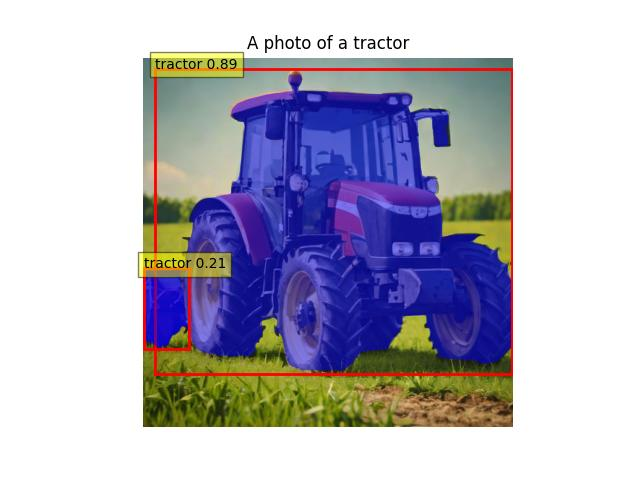

In [3]:
import os
from IPython.display import Image

Image(filename=os.path.join("generated_dataset/bboxes_visualization", "bbox_5.jpg"))

## Convert the dataset to YOLO format

In [4]:
from datadreamer.utils.convert_dataset import convert_dataset

In [5]:
convert_dataset(
    input_dir="generated_dataset",
    output_dir="generated_dataset_yolo",
    dataset_format="yolo",
    split_ratios=[0.8, 0.1, 0.1],
    copy_files=True,
    is_instance_segmentation=True,
)

In [6]:
!ls generated_dataset_yolo

data.yaml  test  train	val


# Train your model (YOLOv8 as an example)

In [7]:
!pip install -q ultralytics

In [8]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")  # load a pretrained model

In [9]:
import os
os.environ['WANDB_DISABLED'] = 'true'

results = model.train(data="generated_dataset_yolo/data.yaml", epochs=200)

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=generated_dataset_yolo/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/generated_dataset_yolo/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 894.59it/s]

train: New cache created: /content/generated_dataset_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/generated_dataset_yolo/val/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 5119.17it/s]

val: New cache created: /content/generated_dataset_yolo/val/labels.cache


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train4
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.78G      0.794      3.071      3.092      1.307         18        640: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          3          3     0.0152          1      0.863      0.688     0.0152          1      0.863      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.74G     0.9745      3.363      3.213      1.413         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all          3          3      0.016          1       0.83      0.665      0.016          1       0.83      0.615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.83G     0.9595      3.171      3.163      1.394         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

                   all          3          3     0.0149          1      0.995      0.813     0.0149          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.76G     0.8419      2.756       3.12      1.332         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]

                   all          3          3     0.0142          1      0.731      0.559     0.0142          1      0.731      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.76G     0.7403      1.975      2.961      1.285         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]

                   all          3          3     0.0148          1      0.591      0.335     0.0148          1      0.618      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.75G     0.5791       1.45      2.634       1.19         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all          3          3     0.0168          1      0.641      0.376     0.0168          1      0.641      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.76G     0.6529      1.048      2.372      1.132         19        640: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all          3          3      0.019          1      0.624      0.402      0.019          1      0.624      0.546

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.73G     0.8078      1.601      2.268      1.313         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

                   all          3          3     0.0208          1       0.83      0.593     0.0208          1       0.83      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.76G     0.8734      1.444      2.121      1.336         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]

                   all          3          3     0.0224          1      0.863      0.638     0.0224          1      0.863      0.737



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.78G      0.794       1.74      1.915      1.337         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]

                   all          3          3     0.0238          1      0.995      0.664     0.0238          1      0.995      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.79G     0.8365      1.086      1.723      1.354         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

                   all          3          3     0.0242          1      0.995      0.751     0.0242          1      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.76G     0.6774       1.02      1.762      1.155         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]

                   all          3          3     0.0221          1      0.995      0.787     0.0221          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.74G     0.6792       1.08      1.827      1.243         16        640: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


                   all          3          3     0.0183          1      0.995      0.753     0.0183          1      0.995       0.94

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.75G     0.7153     0.8324      1.535      1.184         22        640: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

                   all          3          3     0.0165          1      0.995      0.777     0.0165          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.72G      0.691      1.133      1.724      1.273         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]

                   all          3          3     0.0141          1      0.995      0.763     0.0141          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.74G     0.7734       1.09      1.697      1.259         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all          3          3     0.0124          1      0.995       0.73     0.0124          1      0.995      0.863

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.78G     0.8269     0.8279      1.658      1.273         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


                   all          3          3     0.0562          1      0.995      0.752     0.0562          1      0.995       0.69

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.75G     0.7636     0.7614      1.539      1.301         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


                   all          3          3      0.333          1      0.995      0.802      0.333          1      0.995      0.587

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.78G     0.7204     0.9516      1.419      1.197         20        640: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all          3          3    0.00974          1      0.995      0.785    0.00974          1      0.995      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.78G     0.6958      1.272      1.479      1.189         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

                   all          3          3    0.00888          1      0.913      0.672    0.00888          1      0.747      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.78G     0.6758     0.7882      1.464      1.163         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

                   all          3          3    0.00826          1      0.753      0.563    0.00551      0.667      0.556      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.81G      0.931     0.8528      1.548      1.456         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          3          3    0.00794          1      0.995      0.741    0.00794          1      0.995      0.731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.76G      0.883     0.8969      1.455       1.36         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all          3          3    0.00781          1      0.995      0.796    0.00781          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.74G     0.7606      0.711      1.423      1.274         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]

                   all          3          3    0.00744          1      0.995      0.569    0.00744          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.76G     0.7699     0.7434      1.451      1.269         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]

                   all          3          3      0.197          1      0.995      0.569      0.197          1      0.995      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.78G     0.6797     0.7577      1.407      1.112         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all          3          3      0.967          1      0.995      0.752      0.967          1      0.995      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.78G     0.5848     0.7211      1.409      1.127         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

                   all          3          3      0.976          1      0.995       0.84      0.976          1      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.77G      0.874     0.7393      1.373      1.308         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all          3          3      0.976          1      0.995       0.84      0.976          1      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.76G      0.763     0.7376      1.367      1.298         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          3          3          1      0.709      0.995      0.807          1      0.709      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.76G     0.7695     0.6632      1.434      1.225         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


                   all          3          3          1      0.984      0.995      0.719          1      0.984      0.995      0.895

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.75G     0.7186     0.6687      1.374      1.205         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]

                   all          3          3          1      0.984      0.995      0.719          1      0.984      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.78G      0.708     0.7252      1.366      1.183         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]

                   all          3          3      0.979          1      0.995      0.708      0.979          1      0.995      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.78G      0.698     0.9198      1.265      1.175         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

                   all          3          3       0.97          1      0.995      0.763       0.97          1      0.995      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.73G     0.5212     0.6669      1.352      1.122         14        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

                   all          3          3       0.97          1      0.995      0.763       0.97          1      0.995      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.76G     0.6894     0.8063      1.307      1.179         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all          3          3      0.975          1      0.995      0.895      0.975          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.77G     0.6342     0.6469      1.179      1.086         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

                   all          3          3      0.969          1      0.995      0.857      0.969          1      0.995      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.77G     0.8963      1.439      1.324      1.326         25        640: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

                   all          3          3      0.969          1      0.995      0.857      0.969          1      0.995      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.77G     0.6453     0.5816      1.252      1.081         22        640: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]

                   all          3          3       0.97          1      0.995       0.83       0.97          1      0.995      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.76G     0.7483     0.8435      1.437      1.208         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all          3          3          1      0.665      0.913      0.772          1      0.665      0.913      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.77G      0.764     0.6151      1.333      1.262         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all          3          3          1      0.665      0.913      0.772          1      0.665      0.913      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.78G     0.7048      1.037      1.218      1.114         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all          3          3      0.559          1       0.83      0.698      0.559          1       0.83      0.693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200       2.8G     0.6763      0.695      1.257      1.141         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all          3          3      0.486          1      0.753      0.636      0.486          1      0.753      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.76G     0.7237     0.7255      1.244      1.193         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]

                   all          3          3      0.486          1      0.753      0.636      0.486          1      0.753      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.75G     0.8198      1.073      1.391      1.228         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

                   all          3          3      0.727          1      0.913      0.722      0.727          1      0.913      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.77G     0.8204      1.331      1.545      1.275         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all          3          3      0.727          1      0.913      0.722      0.727          1      0.913      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.79G     0.6875     0.8194       1.49      1.173         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all          3          3          1      0.979      0.995      0.686          1      0.979      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.75G     0.8966      1.198      1.514      1.326         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

                   all          3          3          1      0.979      0.995      0.686          1      0.979      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.76G      0.586     0.8328       1.18      1.214         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

                   all          3          3      0.979          1      0.995      0.653      0.979          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.77G     0.6485     0.5949      1.183      1.118         25        640: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


                   all          3          3      0.979          1      0.995      0.653      0.979          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.77G     0.7331       1.04      1.334      1.242         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]

                   all          3          3      0.985          1      0.995      0.896      0.985          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.74G     0.7259     0.8039      1.293      1.195         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all          3          3      0.985          1      0.995      0.896      0.985          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.79G     0.7508     0.9683      1.539      1.202         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all          3          3      0.982          1      0.995      0.912      0.982          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.75G     0.7076     0.6069      1.266      1.159         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

                   all          3          3      0.982          1      0.995      0.912      0.982          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.75G     0.7378     0.7723      1.246      1.216         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]

                   all          3          3      0.986          1      0.995      0.895      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.75G     0.6865     0.8221      1.171      1.182         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all          3          3      0.986          1      0.995      0.895      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.75G     0.5388     0.8311      1.103      1.099         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.79G     0.8337     0.8106       1.37      1.229         18        640: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.75G     0.8342     0.7238       1.28      1.227         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

                   all          3          3      0.973          1      0.995       0.83      0.973          1      0.995      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.75G     0.6904     0.7557      1.099      1.099         26        640: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]

                   all          3          3      0.973          1      0.995       0.83      0.973          1      0.995      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.75G     0.8214     0.8577      1.239       1.26         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


                   all          3          3      0.994          1      0.995      0.735      0.994          1      0.995      0.885

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.75G     0.7685     0.5507      1.197      1.217         21        640: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


                   all          3          3      0.994          1      0.995      0.735      0.994          1      0.995      0.885

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.76G      0.867     0.7007      1.298      1.374         14        640: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all          3          3      0.992          1      0.995       0.84      0.992          1      0.995      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.75G     0.7329     0.6407      1.103      1.182         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all          3          3      0.992          1      0.995       0.84      0.992          1      0.995      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.77G     0.7402      0.809      1.136      1.125         23        640: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

                   all          3          3          1      0.983      0.995      0.807          1      0.983      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.76G     0.5545     0.8058       1.04      1.115         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]

                   all          3          3          1      0.983      0.995      0.807          1      0.983      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.75G      0.888     0.7873      1.457      1.297         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]

                   all          3          3       0.99          1      0.995      0.818       0.99          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.77G     0.7276     0.6194      1.098      1.107         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

                   all          3          3       0.99          1      0.995      0.818       0.99          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.75G     0.5356     0.8722      1.035      1.008         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

                   all          3          3      0.984          1      0.995      0.713      0.984          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.75G     0.7544     0.7592      1.393      1.254         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

                   all          3          3      0.984          1      0.995      0.713      0.984          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.75G     0.6781     0.7027      1.047      1.137         25        640: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all          3          3      0.983          1      0.995      0.697      0.983          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.76G     0.5566     0.5015      1.118      1.096         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

                   all          3          3      0.983          1      0.995      0.697      0.983          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.81G     0.7059     0.5541      1.327      1.252         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]

                   all          3          3      0.924          1      0.995      0.682      0.924          1      0.995      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.76G     0.6503     0.4222      1.137      1.099         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all          3          3      0.924          1      0.995      0.682      0.924          1      0.995      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.77G      0.613      0.597      1.154      1.098         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all          3          3      0.799          1      0.995      0.697      0.799          1      0.995       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.77G     0.7407      0.739      1.281      1.161         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all          3          3      0.799          1      0.995      0.697      0.799          1      0.995       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.75G     0.7392     0.7957      1.107      1.196         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]

                   all          3          3      0.974          1      0.995       0.73      0.974          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.77G     0.5959     0.6653     0.9648      1.081         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all          3          3      0.974          1      0.995       0.73      0.974          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.77G     0.6506     0.5285      1.045      1.119         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]

                   all          3          3      0.984          1      0.995      0.863      0.984          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.81G     0.6239      0.588      1.036      1.048         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all          3          3      0.984          1      0.995      0.863      0.984          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.75G     0.6568     0.7361      1.037      1.155         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]

                   all          3          3      0.986          1      0.995       0.83      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.75G     0.6159      0.588      1.059      1.104         17        640: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

                   all          3          3      0.986          1      0.995       0.83      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.73G     0.7803     0.5306      1.307      1.284         13        640: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]

                   all          3          3      0.987          1      0.995      0.714      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.75G     0.7378     0.7282      1.307      1.223         11        640: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all          3          3      0.987          1      0.995      0.714      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.79G     0.7356     0.5783      1.145      1.187         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]

                   all          3          3      0.987          1      0.995      0.747      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.75G     0.7554     0.5599      1.178      1.238         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all          3          3      0.987          1      0.995      0.747      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200       2.8G      0.689      0.674      1.013      1.138         22        640: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


                   all          3          3      0.987          1      0.995      0.863      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.77G     0.7633     0.7658       1.06      1.244         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all          3          3      0.987          1      0.995      0.863      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.77G     0.6823     0.4675      1.017      1.217         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

                   all          3          3      0.986          1      0.995      0.852      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.79G     0.5818     0.5296     0.9357      1.035         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

                   all          3          3      0.986          1      0.995      0.852      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200       2.8G     0.6256     0.4748      1.006      1.125         13        640: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]

                   all          3          3      0.986          1      0.995      0.852      0.986          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.75G     0.6188     0.5238      1.121      1.126         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

                   all          3          3      0.986          1      0.995      0.852      0.986          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.75G     0.6475     0.5957      1.019      1.118         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]

                   all          3          3      0.986          1      0.995       0.84      0.986          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.79G     0.5474       1.04     0.8371       1.03         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]

                   all          3          3      0.986          1      0.995       0.84      0.986          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.75G     0.6746     0.6793      1.066      1.171         13        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]

                   all          3          3      0.968          1      0.995       0.84      0.968          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.75G       0.66     0.7117     0.9496      1.131         22        640: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all          3          3      0.968          1      0.995       0.84      0.968          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.77G      0.669     0.4866      1.044      1.193         20        640: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]

                   all          3          3      0.968          1      0.995       0.84      0.968          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200       2.8G     0.5996     0.4582     0.9039      1.154         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all          3          3      0.968          1      0.995       0.84      0.968          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.77G     0.6977      1.052      1.111      1.195         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]

                   all          3          3      0.971          1      0.995      0.852      0.971          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.77G     0.5432     0.5559     0.8922      1.064         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          3          3      0.971          1      0.995      0.852      0.971          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.82G     0.6063     0.5036      1.015      1.061         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]

                   all          3          3      0.979          1      0.995      0.895      0.979          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.75G     0.7022     0.5224      1.057      1.146         16        640: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

                   all          3          3      0.979          1      0.995      0.895      0.979          1      0.995       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.77G     0.6843       0.51     0.9352      1.141         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

                   all          3          3      0.986          1      0.995      0.863      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.75G     0.6863     0.5164      1.049      1.209         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

                   all          3          3      0.986          1      0.995      0.863      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.79G      0.566     0.4932     0.8738       1.07         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]

                   all          3          3      0.986          1      0.995      0.756      0.986          1      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.75G     0.6416     0.8384       1.06       1.14         14        640: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          3          3      0.986          1      0.995      0.756      0.986          1      0.995      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.77G     0.6143     0.5127     0.9753      1.151         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]

                   all          3          3      0.987          1      0.995      0.758      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.78G     0.7773      1.029      1.161      1.252         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all          3          3      0.987          1      0.995      0.758      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.75G      0.533     0.4626     0.9247      1.048         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.77G     0.6707     0.4935     0.9969      1.179         12        640: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.77G     0.6729     0.4916      1.083      1.114         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.78G     0.6963     0.5948      1.017      1.136         23        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.75G     0.6316     0.4456     0.9924      1.079         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]

                   all          3          3      0.987          1      0.995      0.852      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.77G     0.5224     0.4967     0.8122      1.025         17        640: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all          3          3      0.987          1      0.995      0.852      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.73G     0.5403     0.4416     0.9397       1.09         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]

                   all          3          3      0.987          1      0.995      0.863      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.75G     0.5727      0.502     0.8876      1.146         13        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]

                   all          3          3      0.987          1      0.995      0.863      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.76G     0.5485     0.5809     0.9535      1.065         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]

                   all          3          3      0.987          1      0.995      0.885      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.75G     0.4955     0.4099     0.8349      1.024         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all          3          3      0.987          1      0.995      0.885      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.75G     0.5923     0.6652     0.9217      1.051         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.77G      0.609     0.4595     0.8211      1.128         21        640: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.75G     0.6231     0.5781      1.006      1.122         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.77G     0.5762     0.9087      0.905       1.08         20        640: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.75G     0.5714     0.4716     0.8216      1.058         24        640: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]

                   all          3          3      0.987          1      0.995      0.907      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.75G     0.5502     0.5089      0.852      1.079         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]

                   all          3          3      0.987          1      0.995      0.907      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.75G     0.6137     0.4057     0.7874       1.09         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all          3          3      0.987          1      0.995      0.907      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.82G     0.5204     0.5034     0.7814     0.9942         22        640: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          3          3      0.987          1      0.995      0.907      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.77G     0.6097     0.7312     0.8403      1.094         23        640: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]

                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.79G      0.492     0.4076     0.7375     0.9588         25        640: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]

                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.77G     0.5917     0.8382     0.9271      1.036         18        640: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.962

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.77G     0.5816     0.5468     0.9033      1.091         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.77G     0.6392     0.4588     0.7785      1.094         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


                   all          3          3      0.986          1      0.995      0.962      0.986          1      0.995      0.962

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.79G     0.5477     0.4129     0.8522      1.083         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all          3          3      0.986          1      0.995      0.962      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.75G     0.6358     0.5506      1.036      1.174         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.75G     0.5177     0.4507      0.809      1.027         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.75G     0.5144     0.4483     0.8161      1.095         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.71G     0.5643     0.4754     0.9486      1.186         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.75G     0.6034     0.5004     0.8993      1.066         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]

                   all          3          3      0.985          1      0.995      0.895      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.77G     0.5833     0.4331     0.7557      1.046         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all          3          3      0.985          1      0.995      0.895      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.76G     0.4614     0.3644     0.7709     0.9599         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.75G      0.514     0.7363     0.7647      1.032         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]

                   all          3          3      0.986          1      0.995      0.912      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.77G     0.6003     0.7076      0.959       1.12         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.77G     0.6165     0.6826      0.918      1.054         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200       2.8G     0.6499      0.604     0.8206      1.139         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.75G     0.4709     0.3645     0.8066      1.069         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.74G     0.5932     0.4871      0.817      1.147         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]

                   all          3          3      0.986          1      0.995       0.94      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.75G     0.5792     0.4397      0.795      1.094         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]

                   all          3          3      0.986          1      0.995       0.94      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.76G     0.5253     0.5255     0.8925      1.031         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.78G      0.555     0.6465     0.7055      1.026         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.77G     0.5269     0.4604     0.8034      1.031         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.75G     0.4203     0.3653     0.6666      1.038         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.75G     0.4719      0.348     0.7072      1.003         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.76G     0.4813     0.6396      0.686      1.036         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.77G     0.4607     0.3515     0.6976      1.038         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.76G     0.4833     0.3946     0.7209     0.9901         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.75G     0.4215     0.4154     0.6492     0.9648         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.73G     0.6319     0.4829     0.9325      1.183         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.74G     0.4604     0.4138     0.7124     0.9908         17        640: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.951

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.77G     0.5167     0.3632     0.7097      1.067         16        640: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]

                   all          3          3      0.985          1      0.995      0.907      0.985          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.77G     0.4502     0.3701     0.6804     0.9987         23        640: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.77G     0.4283     0.3652     0.6534       1.01         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all          3          3      0.986          1      0.995      0.907      0.986          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.75G     0.6556     0.4277     0.7736      1.161         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]

                   all          3          3      0.986          1      0.995      0.885      0.986          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.82G      0.466     0.5268     0.7672     0.9704         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all          3          3      0.986          1      0.995      0.885      0.986          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.77G     0.6334     0.6523     0.8408      1.081         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]

                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.77G     0.6151     0.4005     0.8177      1.146         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.951

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.77G      0.573      0.915     0.8181      1.085         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.75G     0.5735     0.3785     0.8579      1.089         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all          3          3      0.986          1      0.995      0.929      0.986          1      0.995      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.76G     0.4424     0.6388     0.6663      1.006         22        640: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all          3          3      0.986          1      0.995      0.895      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.77G     0.4522     0.4865     0.6884     0.9968         23        640: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all          3          3      0.986          1      0.995      0.895      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.77G     0.5797     0.5913     0.7426      1.044         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.78G     0.5131      0.453      0.919      1.062         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.75G     0.5183     0.3331     0.6984      1.099         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.75G     0.4504     0.4429     0.6613      1.007         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.75G     0.5363     0.4121     0.8426      1.015         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.77G     0.6181     0.4741     0.9122       1.09         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.75G     0.4773     0.5172     0.7039      1.005         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]

                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.75G     0.6147     0.5295     0.8511      1.167         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.75G     0.5011     0.4729     0.6648      1.049         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.79G     0.4915     0.4244     0.7123      1.048         21        640: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.77G     0.5064     0.4514     0.6745      1.077         20        640: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.75G     0.4005     0.3353     0.5836      1.008         21        640: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]

                   all          3          3      0.987          1      0.995      0.912      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.75G     0.6025     0.4374     0.7449      1.085         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.77G     0.4942     0.4212     0.6912      1.056         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.75G     0.5816      0.572     0.8252      1.094         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.74G     0.4526     0.5938     0.6959      1.008         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.76G     0.4136     0.4118     0.6007     0.9834         16        640: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.75G     0.4407     0.4098     0.7066      1.002         18        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.73G     0.6075     0.6999     0.8587      1.085         19        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.75G     0.5467     0.4813     0.8547      1.099         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.78G     0.4071     0.3879     0.6083     0.9642         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.77G     0.4637     0.4227     0.5746      1.018         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.73G     0.6052      0.622     0.7479        1.1         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.67G     0.2912     0.2252     0.8512     0.9826          7        640: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.68G     0.3667     0.3339      0.943      1.032          7        640: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.67G     0.4169     0.2416      1.138      1.108          6        640: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.68G       0.34     0.4287     0.8749     0.9711          7        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.67G     0.2565     0.2773     0.7892     0.9078          7        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

                   all          3          3      0.987          1      0.995      0.895      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.68G      0.357      0.248      1.021      1.044          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.72G     0.3966     0.2981      1.045      1.056          7        640: 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.68G     0.3017     0.3045     0.8399     0.8772          8        640: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.995

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.67G       0.31     0.2672     0.8157      1.029          8        640: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]

                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.68G     0.4499      0.263      1.007      1.119          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]

                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.995



200 epochs completed in 0.093 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 6.8MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


                   all          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.995
               tractor          3          3      0.987          1      0.995      0.962      0.987          1      0.995      0.995
Speed: 0.3ms preprocess, 9.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train4


lr/pg0,▁▂▂▆▇████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁
lr/pg1,▄▄▇▇▇█████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁
lr/pg2,▁▂▂▂▃▅▆▇▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▃▁▂▂▆██████▅████████████████████████████
metrics/mAP50(M),▆▁██████▄███████████████████████████████
metrics/mAP50-95(B),▅▆▁▂▆▇▅▄▅▇▅▅▇▇▆▇▇▇▇▇██▇██▇██▇▇█▇▇▇▇▇▇▇▇█
metrics/mAP50-95(M),▃▆▂▅▆█▁▁▇▇███▇█▇▇▇▇███████████▇▇▇▇███▇██
metrics/precision(B),▁▁▁▁███████▇▇███████████████████████████
metrics/precision(M),▁▁▁▁▁▁▁████████▇████████████████████████
metrics/recall(B),████████▁███████████████████████████████
metrics/recall(M),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Show the predictions

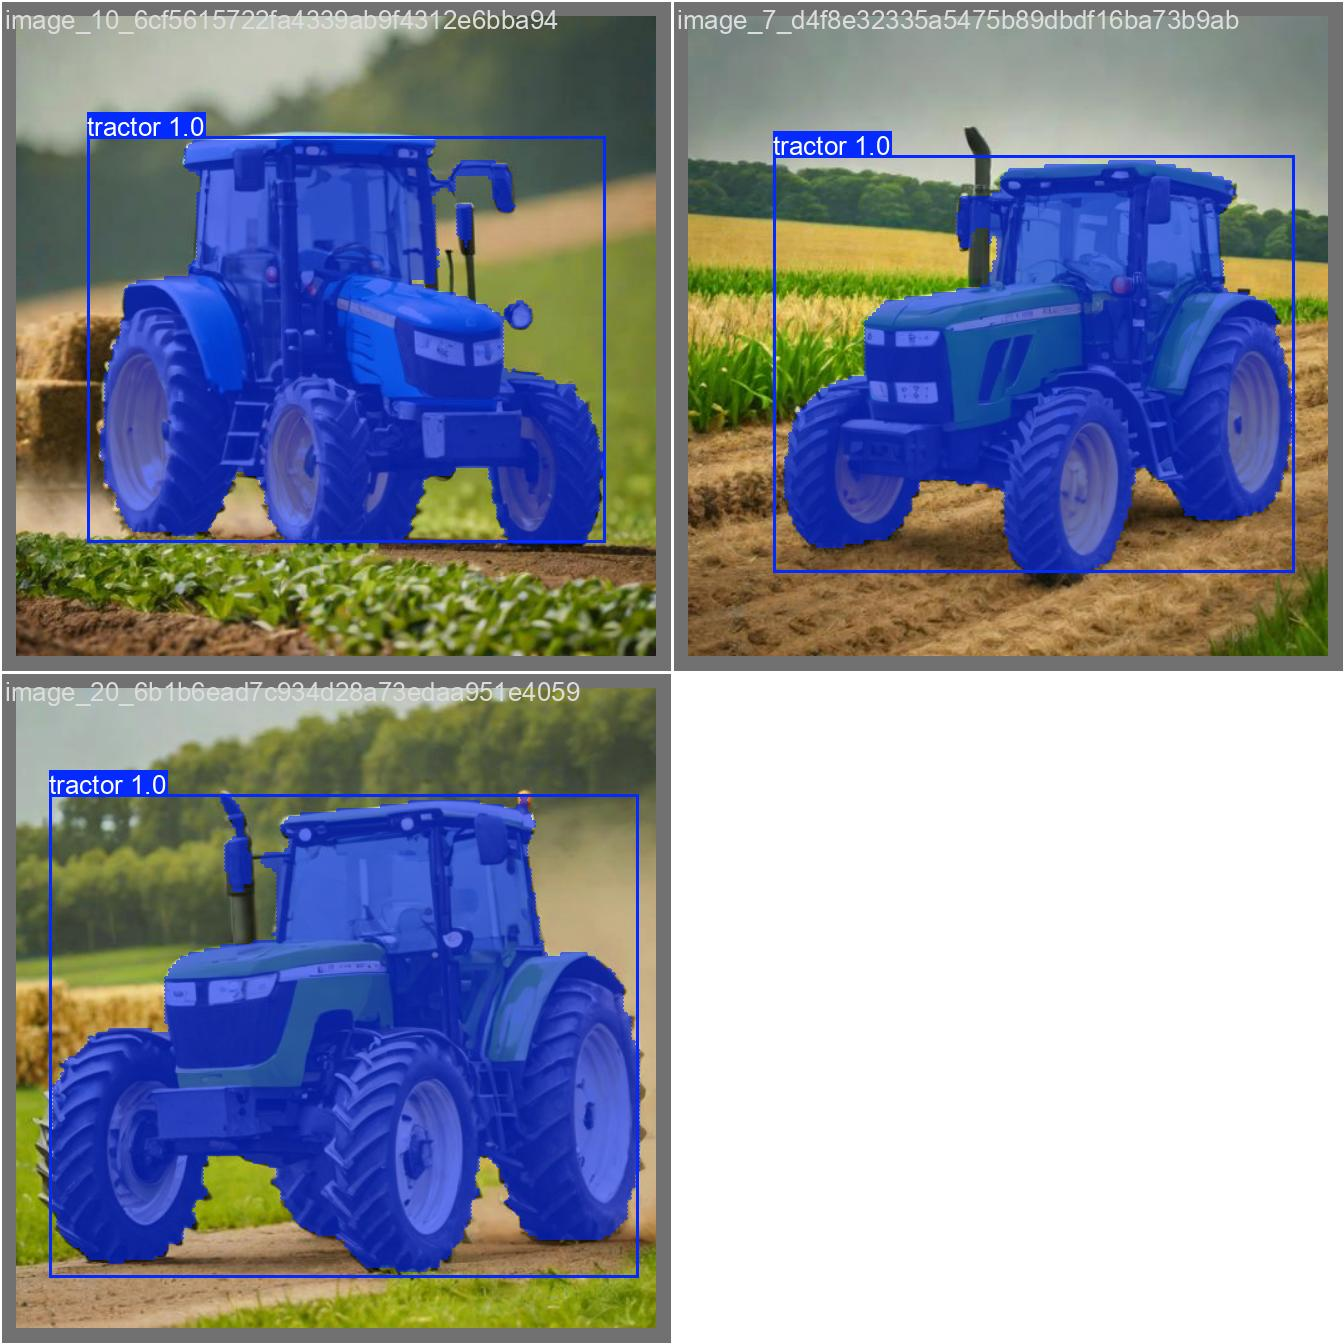

In [10]:
Image(filename=os.path.join(results.save_dir, "val_batch0_pred.jpg"))

In [11]:
metrics = model.val()

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/generated_dataset_yolo/val/labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


                   all          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995
               tractor          3          3      0.987          1      0.995      0.929      0.987          1      0.995      0.995
Speed: 0.4ms preprocess, 48.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train42
